## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [13]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation 

In [14]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_domain_age_clean_5.csv')

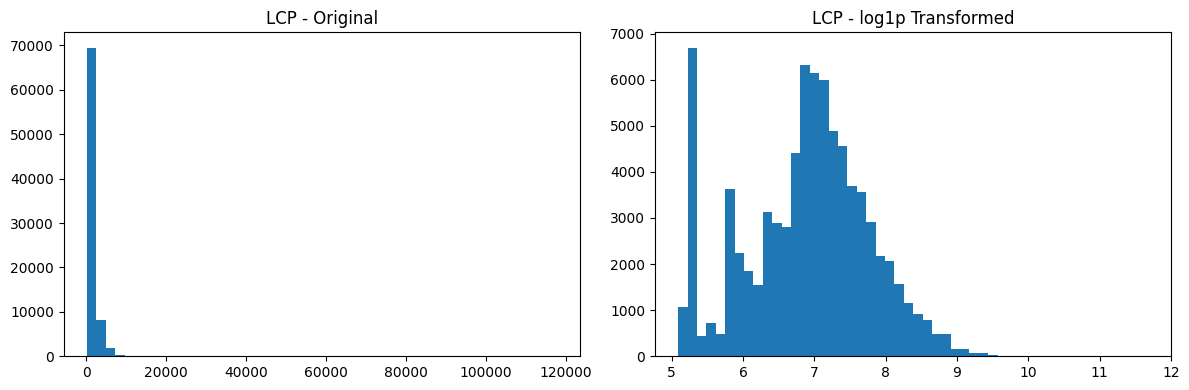

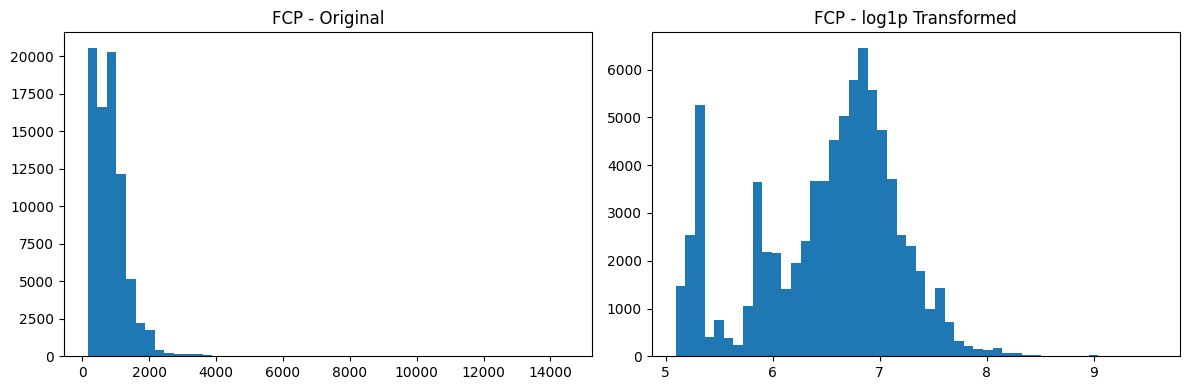

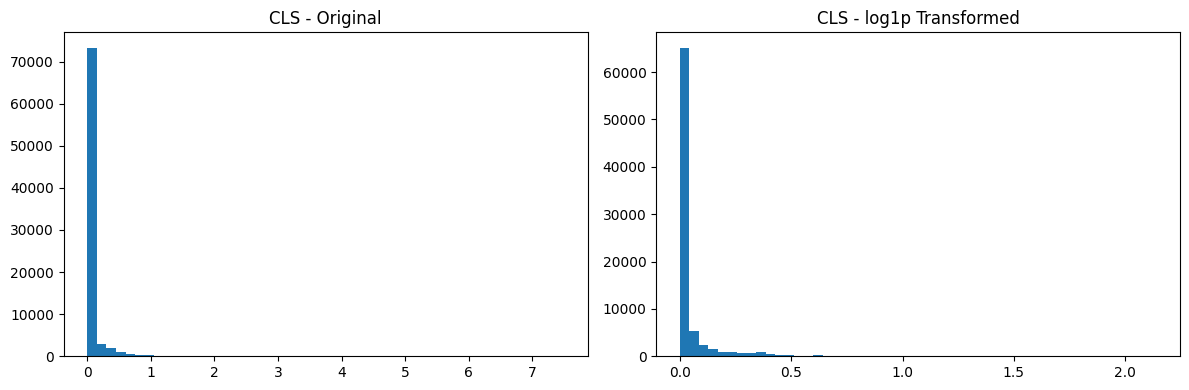

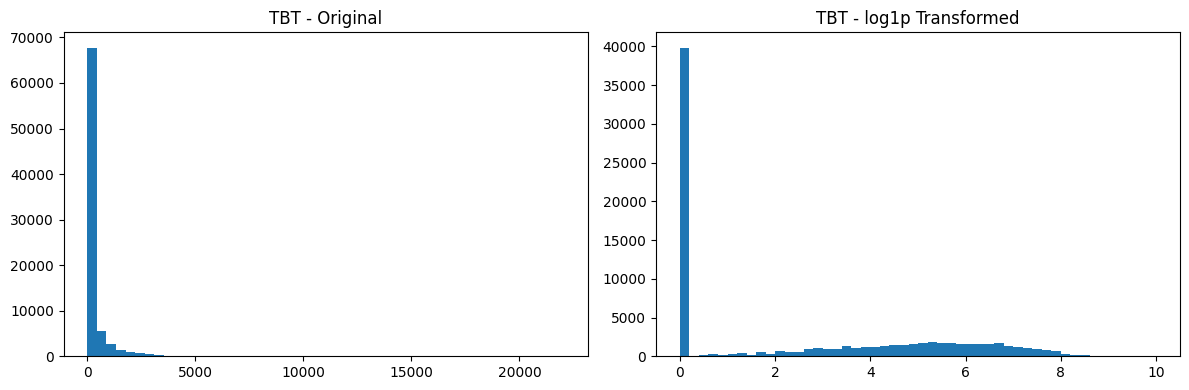

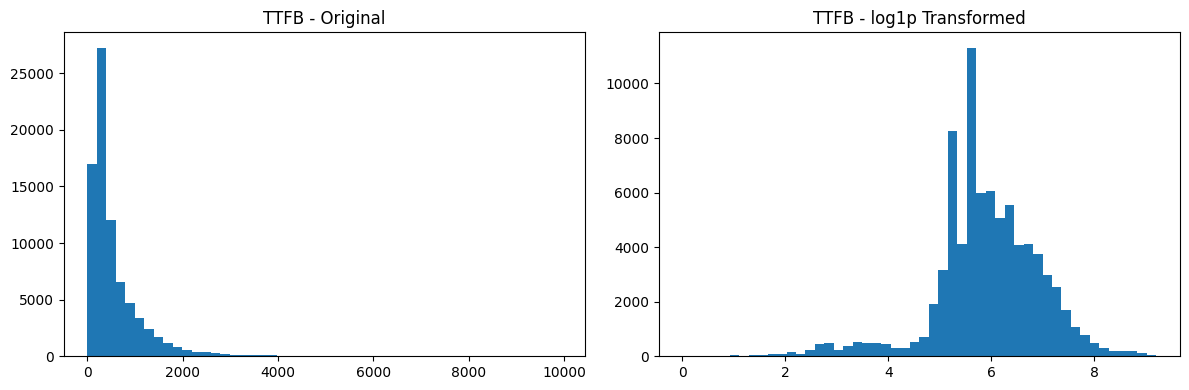

In [15]:
features_to_check = ["LCP", "FCP", "CLS", "TBT" , "TTFB"]

for feat in features_to_check:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[feat].dropna(), bins=50)
    plt.title(f"{feat} - Original")

    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(df[feat].dropna()), bins=50)
    plt.title(f"{feat} - log1p Transformed")

    plt.tight_layout()
    plt.show()


特徴量とラベルに分割

In [16]:
df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)

# log変換対象
df['TTFB_log'] = np.log1p(df['TTFB'])
df['LCP_log'] = np.log1p(df['LCP'])
df['FCP_log'] = np.log1p(df['FCP'])
# df['TBT_log'] = np.log1p(df['TBT'])  # ただし0の多さには注意

# 元の列は除外して、log変換版のみ使用
drop_cols = ['TTFB', 'LCP', 'FCP']
df = df.drop(columns=drop_cols)

# ターゲットと特徴量の分離
y = df['url_type']
X = df.drop(columns=['url_type'])
# X = df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score','title_count','is_domain_in_url'])
X = X.select_dtypes(include=['int64', 'float64', 'bool'])


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80134 entries, 0 to 80133
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   80134 non-null  object 
 1   url_type              80134 non-null  int64  
 2   url_len               80134 non-null  int64  
 3   letters_count         80134 non-null  int64  
 4   digits_count          80134 non-null  int64  
 5   special_chars_count   80134 non-null  int64  
 6   shortened             80134 non-null  int64  
 7   is_domain_in_url      80134 non-null  int64  
 8   secure_http           80134 non-null  int64  
 9   redirect_count        80134 non-null  int64  
 10  duration_sec          80134 non-null  float64
 11  meta_count            80134 non-null  float64
 12  link_count            80134 non-null  float64
 13  title_count           80134 non-null  float64
 14  has_title             80134 non-null  bool   
 15  has_meta_descriptio

学習・検証データに分割

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [19]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

ハイパーパラメータ設定とモデル学習

In [20]:
# Optunaのベストパラメータに固定設定を追加
# best_params = study.best_params.copy()  # ← 上書き防止のため copy()

best_params = {'learning_rate': 0.25198045073380176, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 86,
               'feature_fraction': 0.7139552624284528, 'bagging_fraction': 0.9483688703020394, 'bagging_freq': 1}
# Optunaで得たパラメータ（例: study.best_params を貼り付け）

# GOSS の場合は bagging 系のパラメータ削除（GOSSは使えない）
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# 固定設定を追記
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# データセットの再構築
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# num_boost_round は早期終了されるので大きめにしておく（Optunaでの記録がない場合）
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 30 rounds
[10]	training's multi_logloss: 0.281462	valid_1's multi_logloss: 0.305554
[20]	training's multi_logloss: 0.189364	valid_1's multi_logloss: 0.236885
[30]	training's multi_logloss: 0.151106	valid_1's multi_logloss: 0.216931
[40]	training's multi_logloss: 0.126925	valid_1's multi_logloss: 0.208706
[50]	training's multi_logloss: 0.107838	valid_1's multi_logloss: 0.203311
[60]	training's multi_logloss: 0.0915145	valid_1's multi_logloss: 0.200587
[70]	training's multi_logloss: 0.0786356	valid_1's multi_logloss: 0.199349
[80]	training's multi_logloss: 0.068047	valid_1's multi_logloss: 0.198506
[90]	training's multi_logloss: 0.0589583	valid_1's multi_logloss: 0.199147
[100]	training's multi_logloss: 0.0514594	valid_1's multi_logloss: 0.198961
Early stopping, best iteration is:
[78]	training's multi_logloss: 0.0697004	valid_1's multi_logloss: 0.198447


予測と評価

In [21]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n🧩 전체 클래스 간 오분류 분석")

# 클래스 목록 가져오기 (0,1,2 외의 클래스도 대응 가능)
classes = sorted(set(y_test) | set(y_pred))

# y_test와 y_pred가 시리즈일 경우를 고려하여 numpy 배열로 변환
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# 모든 클래스 쌍 (i ≠ j)에 대해 루프
for i in classes:
    for j in classes:
        if i == j:
            continue  # 정답인 경우는 건너뜀 (오분류만 분석)

        # i → j로 오분류된 인스턴스를 찾음
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\n🔍 클래스 {i} → 클래스 {j} 로 오분류된 인스턴스 수: {misclassified_mask.sum()}")
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n✅ 클래스 {i} → 클래스 {j} 오분류 없음")

📊 Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5745
           1       0.97      1.00      0.98      5405
           2       0.88      0.85      0.87      4877

    accuracy                           0.92     16027
   macro avg       0.92      0.92      0.92     16027
weighted avg       0.92      0.92      0.92     16027

🧩 Confusion Matrix
[[5196   13  536]
 [   5 5381   19]
 [ 572  144 4161]]

🧩 전체 클래스 간 오분류 분석

🔍 클래스 0 → 클래스 1 로 오분류된 인스턴스 수: 13
          url_len  letters_count  digits_count  special_chars_count  \
count   13.000000      13.000000     13.000000            13.000000   
mean    86.307692      72.153846      5.230769            15.923077   
std     16.630217      13.477427      2.618964             2.956956   
min     76.000000      63.000000      2.000000            14.000000   
25%     77.000000      65.000000      4.000000            15.000000   
50%     80.000000      66.000000      5.0

重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

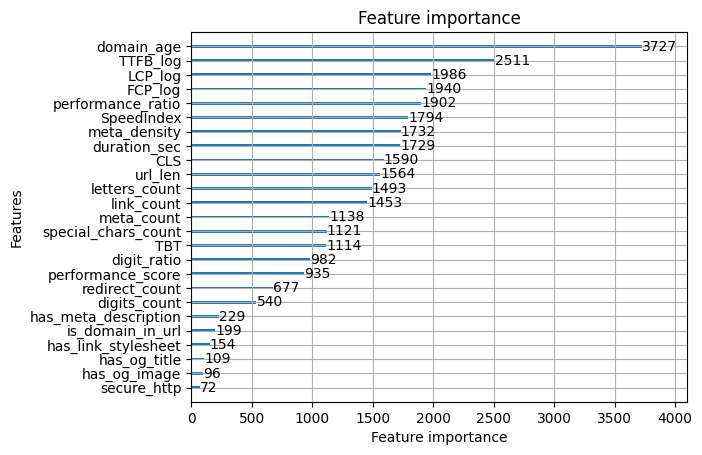

In [11]:
lgb.plot_importance(model, max_num_features=25)